# medMNIST exploration

In [25]:
import medmnist
print(medmnist.__version__)

3.0.2


In [1]:
import torch
import torchvision

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")


Torch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124


In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [3]:
# show my GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# check if GPU is available
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory allocated: {torch.cuda.memory_allocated(0) / (1024 ** 3):.2f} GB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved(0) / (1024 ** 3):.2f} GB")
else:
    print("No GPU available, using CPU instead.")


Using device: cuda
GPU name: NVIDIA GeForce GTX 1080 Ti
GPU memory allocated: 0.00 GB
GPU memory cached: 0.00 GB


In [4]:
# read in the PneumoniaMNIST dataset
from medmnist import PneumoniaMNIST
train_dataset = PneumoniaMNIST(split='train', download=True, size=224)
test_dataset = PneumoniaMNIST(split='test', download=True, size=224)
val_dataset = PneumoniaMNIST(split='val', download=True, size=224)
# print the dataset info
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 4708
Number of test samples: 624


In [5]:
print(type(train_dataset[0]))
print(len(train_dataset[0]))
image, label = train_dataset[0]
print(type(image))


<class 'tuple'>
2
<class 'PIL.Image.Image'>


In [6]:
from matplotlib import pyplot as plt

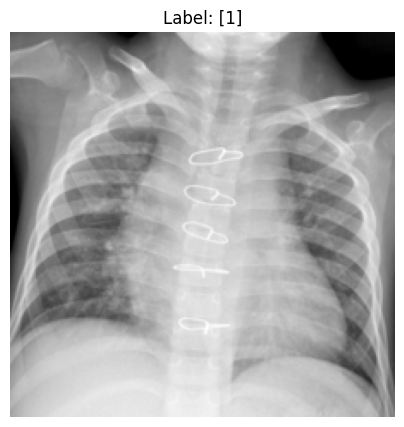

In [7]:
# print 1st 10 samples
for i in range(1):
    image, label = train_dataset[i]
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray' if image.mode == 'L' else None)
    plt.title(f"Label: {label}")
    plt.axis('off')  # Hide the axes
    plt.show()

In [8]:
# number of samples of each class
postive_count = sum(1 for _, label in train_dataset if label == 1)
negative_count = sum(1 for _, label in train_dataset if label == 0)
print(f"Number of positive samples: {postive_count}")
print(f"Number of negative samples: {negative_count}")

Number of positive samples: 3494
Number of negative samples: 1214


In [9]:
info =INFO['pneumoniamnist']
print(info)
n_channels = info['n_channels']
n_classes = info['label']
print("Number of channels:",n_channels)
print("Number of classes",n_classes)

{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1', 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6', 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1', 'MD5_128': '05b46931834c231683c68f40c47b2971', 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1', 'MD5_224': 'd6a3c71de1b945ea11211b

In [10]:
dataiter = iter(train_dataset)
image, label = next(dataiter)
print(image.size)
print(label.shape)

(224, 224)
(1,)


### Hyperparameters
* BATCH_SIZE
* LEARNING_RATE
* NUM_EPOCHS
* IMAGE_SIZE
* NUM_CLASSES
* NUM_CHANNELS

### Data transformations
* Transform to tensor
* Normalize

### Create the dataloaders


In [11]:
BATCH_SIZE = 32
LEARNING_RATE = 0.01
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset.transform = data_transforms
test_dataset.transform = data_transforms
val_dataset.transform = data_transforms


train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

dataiter = iter(train_loader)
image, label = next(dataiter)
print(image.shape)
print(label.shape)



Train dataset size: 4708
Test dataset size: 624
Validation dataset size: 524
torch.Size([32, 1, 224, 224])
torch.Size([32, 1])


### Create the SequentialNN classifier class

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()
        #Convoluional layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 224x224 -> 112x112
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 112x112 -> 56x56
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 56x56 -> 28x28
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 28x28 -> 14x14
        )

        # Calculate the flattened size dynamically (or pre-calculate)
        # After 4 pooling layers (2x2 stride), the size is 224 / (2^4) = 224 / 16 = 14
        # Flattened size = channels * height * width = 256 * 14 * 14
        self.flattened_size = 256 * 14 * 14

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.relu_fc = nn.ReLU()
        # Output layer: num_classes=1 for binary classification (outputting logits)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.fc1(x)
        x = self.relu_fc(x)
        x = self.fc2(x) # Output raw logits
        return x


In [13]:
# Instantiate the model and move it to the device
model = SimpleCNN(in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES).to(device)
print(model)

# Optional: Print model summary (requires torchsummary)
from torchsummary import summary
summary(model, (NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (relu_fc): ReLU()
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)
-----------------------------

In [14]:
import torchmetrics

In [15]:
# Loss function
# BCEWithLogitsLoss combines Sigmoid layer and BCELoss in one single class.
# It's more numerically stable than using a plain Sigmoid followed by BCELoss.
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Metrics using torchmetrics (more robust than manual calculation)
# We need 'BinaryAccuracy' and potentially 'BinaryAUROC' for binary tasks.
# Make sure to move metrics objects to the correct device.
train_accuracy_metric = torchmetrics.Accuracy(task="binary").to(device)
val_accuracy_metric = torchmetrics.Accuracy(task="binary").to(device)
val_auc_metric = torchmetrics.AUROC(task="binary").to(device)
roc_metric = torchmetrics.ROC(task="binary").to(device)

### Understanding of each dataset
* Training Set: Used directly by the optimizer to learn the model parameters (weights and biases). The model sees these examples and their labels repeatedly. Performance on this set indicates how well the model is fitting the data it's learning from.
* Validation Set: Used during the training process (typically after each epoch) to evaluate the model's generalization ability on data it hasn't been trained on. This helps in:
* - Monitoring for overfitting (training performance improves, validation performance stagnates or degrades).
* - Hyperparameter tuning (e.g., choosing the best learning rate, network architecture).
* - Early stopping (stopping training when validation performance stops improving).
* Test Set: Used only once after the final model (chosen based on validation performance and finalized hyperparameters) has been trained. It provides an unbiased estimate of the model's performance on completely unseen data, simulating real-world performance.

In [16]:
def train_one_epoch(model, loader, criterion, optimizer, device, epoch, accuracy_metric):
    model.train()  # Set model to training mode (enables dropout/batchnorm updates)
    running_loss = 0.0
    accuracy_metric.reset() # Reset metric at the start of epoch

    # Use tqdm for a progress bar
    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)

    for i, (inputs, labels) in enumerate(progress_bar):
        inputs = inputs.to(device)
        # Labels need to be float and match the output shape for BCEWithLogitsLoss
        # Original labels might be Long, convert to Float.
        # The output of the model is [batch_size, 1], labels should be [batch_size, 1] or [batch_size]
        #labels = labels.float().unsqueeze(1).to(device) # Add dimension if necessary
        labels = labels.float().to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs) # Shape: [batch_size, 1] (logits)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * inputs.size(0) # loss.item() is avg loss per batch

        # Update metrics (expects probabilities or logits)
        # Pass outputs directly (logits) or torch.sigmoid(outputs) (probabilities)
        accuracy_metric.update(outputs, labels.int()) # Accuracy metric often needs integer labels

        # Update progress bar description
        if (i + 1) % 50 == 0 or i == len(loader) - 1:
             progress_bar.set_postfix(loss=loss.item(), acc=accuracy_metric.compute().item())


    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_metric.compute()
    print(f"Epoch {epoch+1} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc



In [17]:
def validate_one_epoch(model, loader, criterion, device, accuracy_metric, auc_metric, roc_metric):
    model.eval()   # Set model to evaluation mode (disables dropout/batchnorm updates)
    running_loss = 0.0
    accuracy_metric.reset()
    auc_metric.reset()
    roc_metric.reset()

    progress_bar = tqdm(loader, desc="           [Validate]", leave=False)

    with torch.no_grad(): # Disable gradient calculations for validation
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            #labels = labels.float().unsqueeze(1).to(device) # Ensure float and correct shape
            labels = labels.float().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            # Update metrics
            accuracy_metric.update(outputs, labels.int())
            auc_metric.update(outputs, labels.int()) # AUC metric also needs integer labels
            roc_metric.update(outputs, labels.int())

            progress_bar.set_postfix(loss=loss.item(), acc=accuracy_metric.compute().item(), auc=auc_metric.compute().item())


    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_metric.compute()
    epoch_auc = auc_metric.compute()
    epoch_roc = roc_metric.compute() # Get ROC curve (if needed)
    print(f"         Validation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC: {epoch_auc:.4f}")
    return epoch_loss, epoch_acc, epoch_auc, epoch_roc



In [18]:

def test_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    # Use fresh metric instances for testing
    test_accuracy_metric = torchmetrics.Accuracy(task="binary").to(device)
    test_auc_metric = torchmetrics.AUROC(task="binary").to(device)
    # Add other relevant metrics if needed (Precision, Recall, F1)
    test_precision_metric = torchmetrics.Precision(task="binary").to(device)
    test_recall_metric = torchmetrics.Recall(task="binary").to(device)
    test_f1_metric = torchmetrics.F1Score(task="binary").to(device)
    test_roc_metric = torchmetrics.ROC(task="binary").to(device)

    print("\nStarting Testing...")
    progress_bar = tqdm(loader, desc="[Test]", leave=False)

    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            #labels = labels.float().unsqueeze(1).to(device)
            labels = labels.float().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            # Update all test metrics
            int_labels = labels.int()
            test_accuracy_metric.update(outputs, int_labels)
            test_auc_metric.update(outputs, int_labels)
            test_precision_metric.update(outputs, int_labels)
            test_recall_metric.update(outputs, int_labels)
            test_f1_metric.update(outputs, int_labels)
            test_roc_metric.update(outputs, int_labels)

    test_loss = running_loss / len(loader.dataset)
    test_acc = test_accuracy_metric.compute()
    test_auc = test_auc_metric.compute()
    test_precision = test_precision_metric.compute()
    test_recall = test_recall_metric.compute()
    test_f1 = test_f1_metric.compute()
    test_roc = test_roc_metric.compute() # Get ROC curve if needed


    print("\n--- Test Results ---")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")
    print("--------------------")


    # It's good practice to clean up metric states
    test_accuracy_metric.reset()
    test_auc_metric.reset()
    test_precision_metric.reset()
    test_recall_metric.reset()
    test_f1_metric.reset()
    test_roc_metric.reset()

    return test_roc



In [19]:
# --- Placeholder for storing history ---
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_aucs = [] # Store validation AUC
val_rocs = [] # Store validation ROC

In [20]:
# --- Main Training Execution ---
NUM_EPOCHS = 2
print("\nStarting Training...")
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, train_accuracy_metric)
    val_loss, val_acc, val_auc, val_roc = validate_one_epoch(model, val_loader, criterion, device, val_accuracy_metric, val_auc_metric, roc_metric)

    # Store metrics for plotting later
    train_losses.append(train_loss)
    train_accs.append(train_acc.item()) # Get scalar value from tensor
    val_losses.append(val_loss)
    val_accs.append(val_acc.item())
    val_aucs.append(val_auc.item())
    val_rocs.append(val_roc) # Store ROC curve if needed

print("Training Finished!")


Starting Training...


Epoch 1 Train Loss: 2.5374 Acc: 0.8507


         Validation Loss: 0.2064 Acc: 0.9179 AUC: 0.9829


Epoch 2 Train Loss: 0.1557 Acc: 0.9410


         Validation Loss: 0.1235 Acc: 0.9523 AUC: 0.9871
Training Finished!


In [21]:
# Run testing
test_roc = test_model(model, test_loader, criterion, device)


Starting Testing...



--- Test Results ---
Test Loss: 0.5771
Test Accuracy: 0.8365
Test AUC: 0.9182
Test Precision: 0.7988
Test Recall: 0.9872
Test F1-Score: 0.8830
--------------------


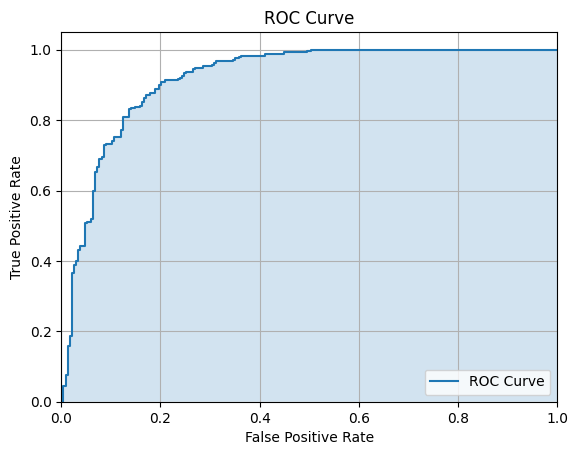

In [22]:
#plot the roc curve
import matplotlib.pyplot as plt
plt.figure
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(test_roc[0].cpu(), test_roc[1].cpu(), label="ROC Curve")
plt.fill_between(test_roc[0].cpu(), test_roc[1].cpu(), alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc="lower right")
plt.show()


## Cost sensitive learning implementation

* Create a variable that will give the number of classifiers
* Weights are between 0.001 to 0.999
* calculate pos_weight to be used with the BCE loss function

In [23]:
NUM_CLASSIFIERS = 10
w = np.linspace(0.001, 0.999, NUM_CLASSIFIERS, endpoint=True)
pos_weights = w/(1-w)


* loop throught the pos_weights and train NUM_CLASSIFIER classifiers

In [ ]:
from sklearn.metrics import confusion_matrix

fpr_weighted = []
tpr_weighted = []

for pos_weight in pos_weights:
    print(f"Positive weight: {pos_weight:.3f}")
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(device))
    model = SimpleCNN(in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Train and validate the model
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, train_accuracy_metric)
        val_loss, val_acc, val_auc, val_roc = validate_one_epoch(model, val_loader, criterion, device, val_accuracy_metric, val_auc_metric, roc_metric)

   # Manual Inference and Metric Calculation
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"[Test - pos_weight={pos_weight:.3f}]", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predictions = (torch.sigmoid(outputs) > 0.5).float() #Binary predictions
            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    #Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    tn, fp, fn, tp = cm.ravel()
    test_accuracy = (tp + tn) / (tp + tn + fp + fn)
    test_precision = tp / (tp + fp) if (tp + fp) > 0 else float('nan')
    test_recall = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall) > 0 else float('nan')
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")

    #Calculate FPR and TPR
    fpr = fp / (fp + tn) if (fp + tn) > 0 else float('nan')
    tpr = tp / (tp + fn) if (tp + fn) > 0 else float('nan')

    fpr_weighted.append(fpr)
    tpr_weighted.append(tpr)





Positive weight: 0.001


Epoch 1 Train Loss: 0.0232 Acc: 0.2579


         Validation Loss: 0.0052 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.0052 Acc: 0.2579


         Validation Loss: 0.0057 Acc: 0.2576 AUC: 0.5037


Positive weight: 0.126


Epoch 1 Train Loss: 1.2144 Acc: 0.2715


         Validation Loss: 0.2052 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.2038 Acc: 0.2579


         Validation Loss: 0.2036 Acc: 0.2576 AUC: 0.5000


Positive weight: 0.287


Epoch 1 Train Loss: 1.1351 Acc: 0.8309


         Validation Loss: 0.1452 Acc: 0.8760 AUC: 0.9830


Epoch 2 Train Loss: 0.0706 Acc: 0.9390


         Validation Loss: 0.0755 Acc: 0.9542 AUC: 0.9914


Positive weight: 0.501


Epoch 1 Train Loss: 2.5620 Acc: 0.3653


         Validation Loss: 0.4262 Acc: 0.2576 AUC: 0.5000


Epoch 2 Train Loss: 0.4265 Acc: 0.3331


         Validation Loss: 0.4260 Acc: 0.2576 AUC: 0.5000


Positive weight: 0.800


Epoch 1 Train Loss: 2.7180 Acc: 0.8112


         Validation Loss: 0.1465 Acc: 0.9313 AUC: 0.9822


Epoch 2 Train Loss: 0.1511 Acc: 0.9365


         Validation Loss: 0.1223 Acc: 0.9427 AUC: 0.9857


Positive weight: 1.249


Epoch 1 Train Loss: 4.4256 Acc: 0.7222


         Validation Loss: 0.6386 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 0.6265 Acc: 0.7421


         Validation Loss: 0.6308 Acc: 0.7424 AUC: 0.5000


Positive weight: 1.997


Epoch 1 Train Loss: 3.5748 Acc: 0.6950


         Validation Loss: 0.5759 Acc: 0.7615 AUC: 0.8675


Epoch 2 Train Loss: 0.3843 Acc: 0.8787


         Validation Loss: 0.2471 Acc: 0.9466 AUC: 0.9805


Positive weight: 3.489


Epoch 1 Train Loss: 5.4609 Acc: 0.8528


         Validation Loss: 0.1982 Acc: 0.9542 AUC: 0.9868


Epoch 2 Train Loss: 0.2211 Acc: 0.9499


         Validation Loss: 0.1860 Acc: 0.9618 AUC: 0.9900


Positive weight: 7.937


Epoch 1 Train Loss: 9.1046 Acc: 0.8037


         Validation Loss: 0.6134 Acc: 0.7901 AUC: 0.9709


Epoch 2 Train Loss: 0.3742 Acc: 0.9053


         Validation Loss: 0.2445 Acc: 0.9408 AUC: 0.9881


Positive weight: 999.000


Epoch 1 Train Loss: 2983.3301 Acc: 0.7103


         Validation Loss: 65.1475 Acc: 0.7424 AUC: 0.5000


Epoch 2 Train Loss: 50.0366 Acc: 0.7421


         Validation Loss: 24.0871 Acc: 0.7424 AUC: 0.5000


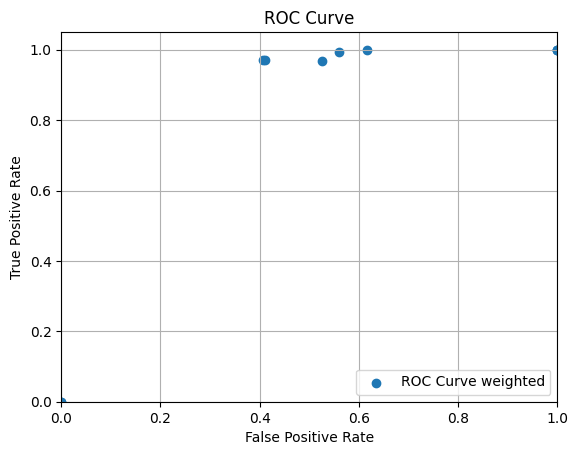

In [33]:
#plot the roc curve
import matplotlib.pyplot as plt
plt.figure
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.scatter(fpr_weighted, tpr_weighted, label="ROC Curve weighted")
#plt.fill_between(test_roc[0].cpu(), test_roc[1].cpu(), alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc="lower right")
plt.show()